In [1]:
import os
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage

from dataset import PascalDataset
from neural_nets import *
from losses import PSNRLoss
from train import train, show_examples

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

toPil = ToPILImage()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.empty_cache()
device = 'cuda:0' if torch.has_cuda else 'cpu:0'
device

'cuda:0'

In [4]:
N_IMAGES = 5011

input_dir = os.path.join('data', 'VOCdevkit', 'VOC2007')
models_path = './models'
logs_path = './logs'
columns_names = ['epoch', 'train_loss', 'validation_loss', 'psnr']

test_set_indices = range(1000)
train_set_indices = range(1000, N_IMAGES)

train_loader = DataLoader(PascalDataset(input_dir, indices=train_set_indices), 
                          batch_size=16, shuffle=True, num_workers=8)

val_loader = DataLoader(PascalDataset(input_dir, indices=test_set_indices), 
                          batch_size=4, shuffle=False, num_workers=8)

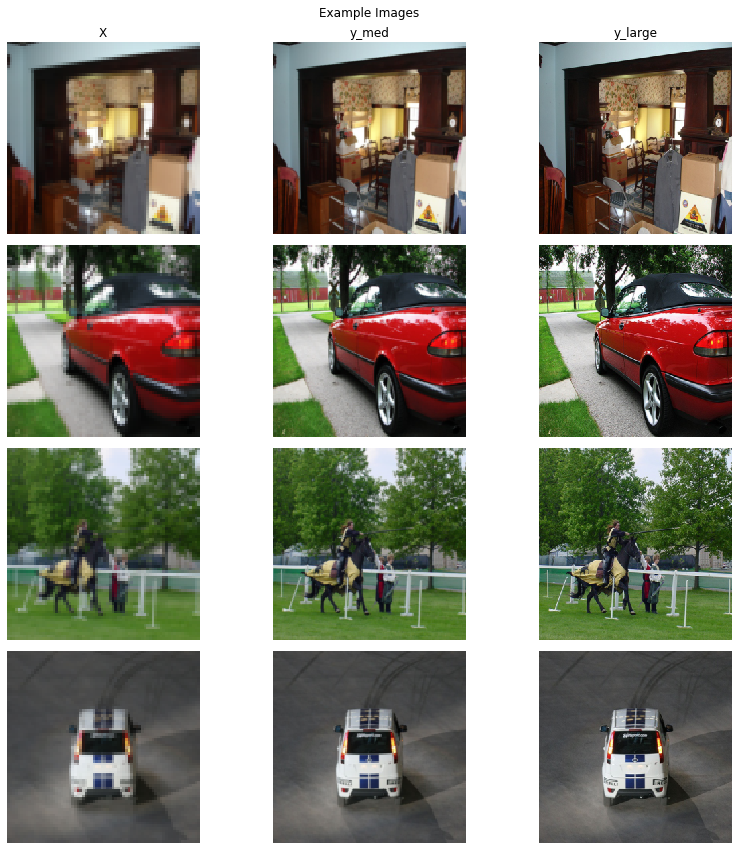

In [5]:
dataiter = iter(val_loader)
examples = dataiter.next()

fig, axes = plt.subplots(nrows=examples[0].size(0), ncols=len(examples), 
                         figsize=(12, 12))

cols = ['X', 'y_med', 'y_large']

for i, row_axes in enumerate(axes):
    
    for j, ax in enumerate(row_axes):
        ax.imshow(toPil(examples[j][i]))
    row_axes[0].set_ylabel(f'example #{i+1}', rotation=90, size='large')
    [ax.set_axis_off() for ax in row_axes]
    
    if i == 0:
        for ax, col in zip(row_axes, cols):
            ax.set_title(col)

fig.suptitle('Example Images')
fig.tight_layout(rect=[0, 0, 1, 0.97])


In [6]:
LR = 5e-4
NUM_EPOCHS = 100
# criterion = MSE(weights=[1, 3])
criterion = PSNRLoss(weights=[1, 3])

### Step 2:  Baseline

In [7]:
base_model = FullConvBase()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, base_model.parameters()), lr=LR)

Start training



Finished training


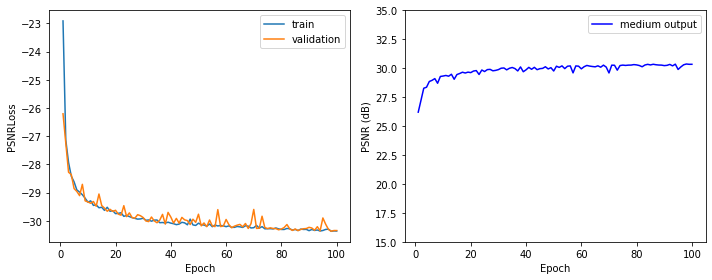

In [8]:
base_log = train(base_model, train_loader, val_loader, criterion, optimizer, device, 
                 num_epochs=NUM_EPOCHS, return_log=True)
torch.save(base_model, os.path.join(models_path, 'base_model.pt'))

df_base = pd.DataFrame(data=base_log, columns=columns_names)
df_base.psnr = df_base.psnr.apply(lambda x: x[0])
df_base.to_csv(os.path.join(logs_path, 'base_model.csv'), header=True, index=False)

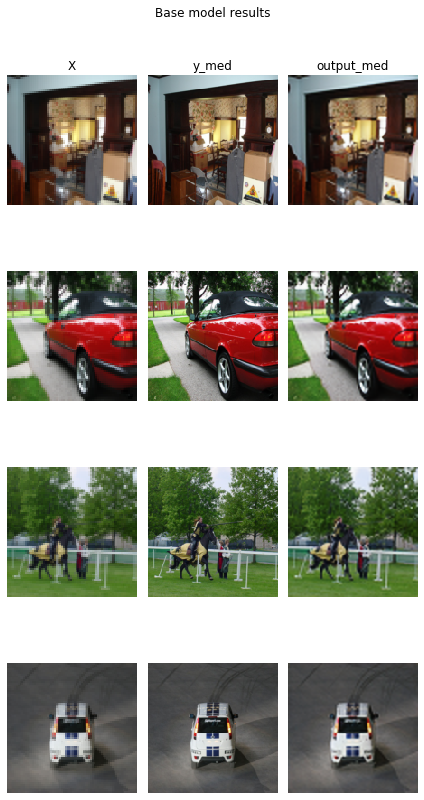

In [9]:
show_examples(examples, base_model, device, title='Base model results')

### Step 3:  Convolutional Net

In [10]:
large_model = FullConvLarge()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, large_model.parameters()), lr=LR)

Start training



Finished training


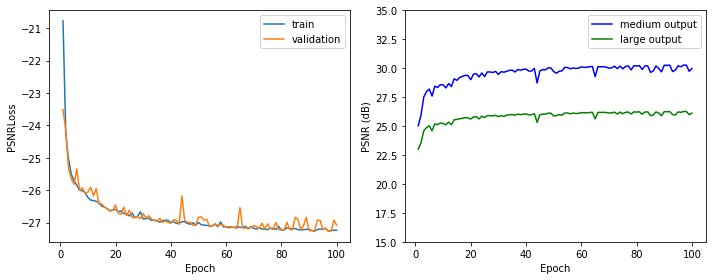

In [11]:
large_log = train(large_model, train_loader, val_loader, criterion, optimizer, device, 
                  num_epochs=NUM_EPOCHS, return_log=True)

torch.save(large_model, os.path.join(models_path, 'large_model.pt'))

df_large = pd.DataFrame(data=large_log, columns=columns_names)
df_large = df_large.join(pd.DataFrame(df_large['psnr'].values.tolist(), 
                                      columns=['psnr_med', 'psnr_large'])).drop('psnr', axis=1)

df_large.to_csv(os.path.join(logs_path, 'large_model.csv'), header=True, index=False)

            

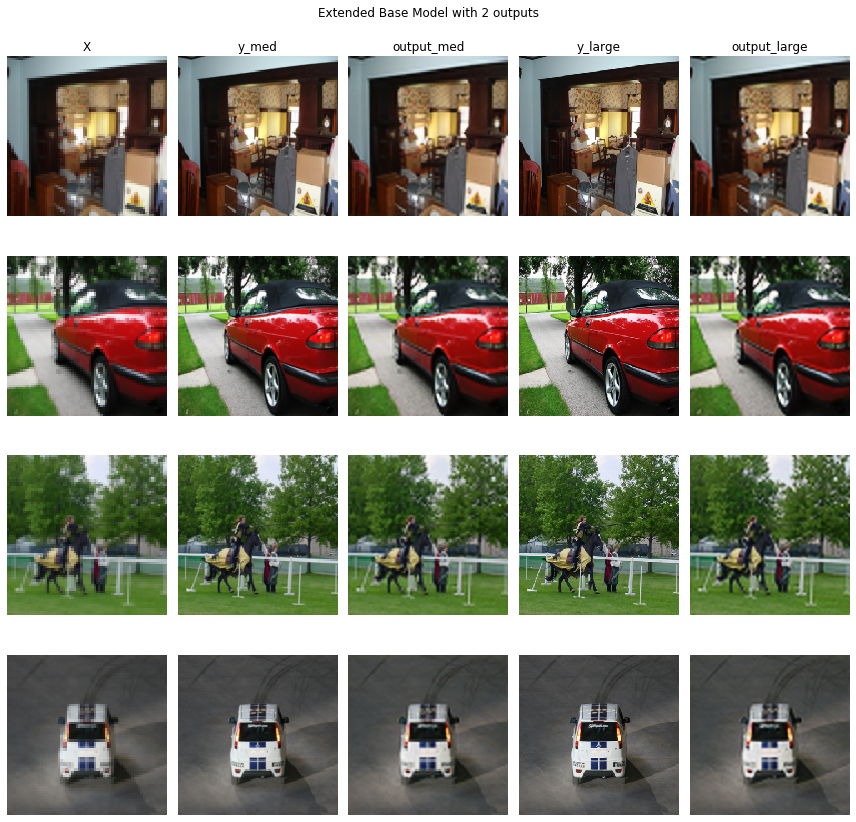

In [12]:
show_examples(examples, large_model, device, title='Extended Base Model with 2 outputs')

### Step 4:  Residual Net

In [13]:
resnet_model = ResidualNet()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=LR)

Start training



Finished training


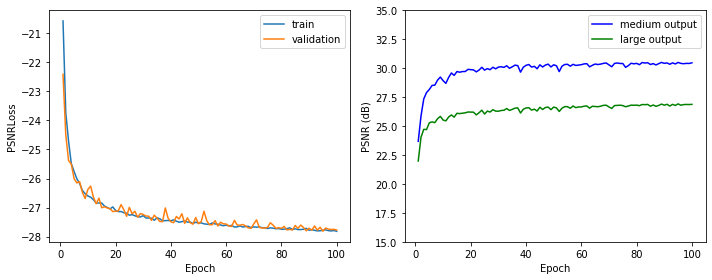

In [14]:
resnet_log = train(resnet_model, train_loader, val_loader, criterion, optimizer, device, 
                   num_epochs=NUM_EPOCHS, return_log=True)

torch.save(resnet_model, os.path.join(models_path, 'resnet_model.pt'))

resnet_df = pd.DataFrame(data=resnet_log, columns=columns_names)
resnet_df = resnet_df.join(pd.DataFrame(resnet_df['psnr'].values.tolist(), 
                                        columns=['psnr_med', 'psnr_large'])).drop('psnr', axis=1)

resnet_df.to_csv(os.path.join(logs_path, 'resnet_model.csv'), header=True, index=False)


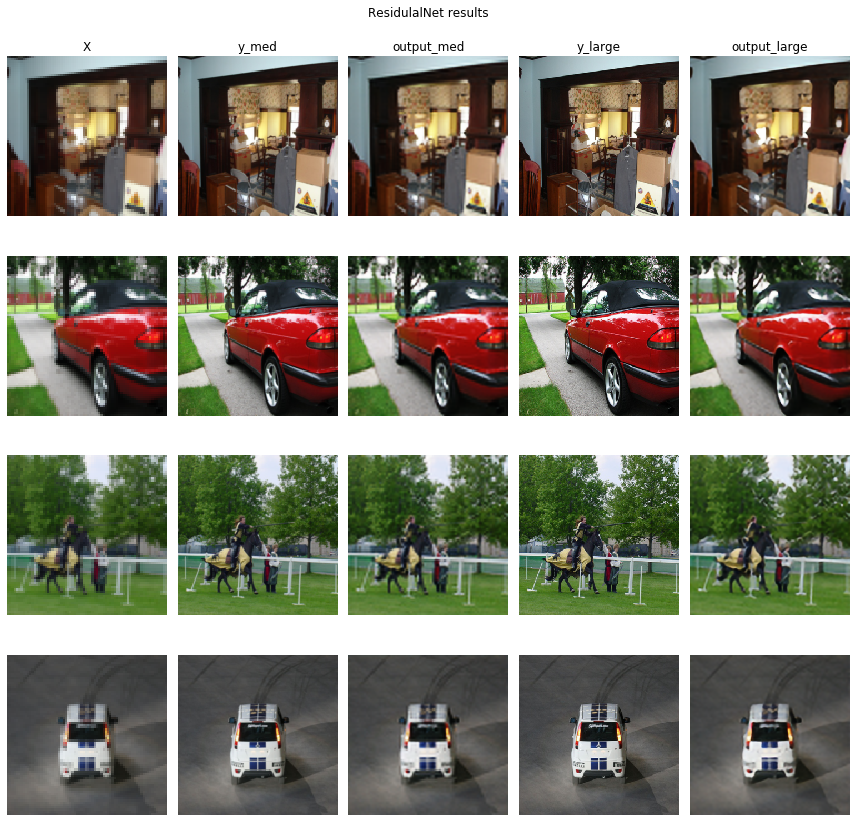

In [15]:
show_examples(examples, resnet_model, device, title='ResidulalNet results')

### Step 5: Dilated Net

In [16]:
dilated_model = DilatedNet()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, dilated_model.parameters()), lr=LR)

Start training



Finished training


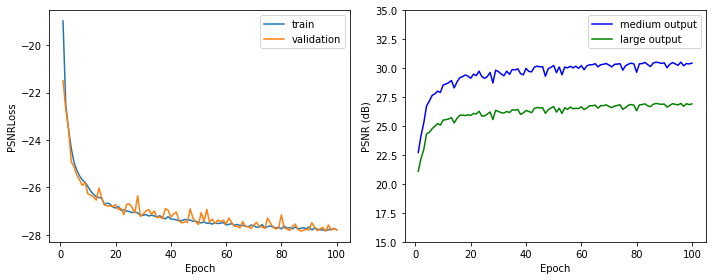

In [17]:
dilated_log = train(dilated_model, train_loader, val_loader, criterion, optimizer, device, 
                    num_epochs=NUM_EPOCHS, return_log=True)

torch.save(dilated_model, os.path.join(models_path, 'dilated_model.pt'))

dilated_df = pd.DataFrame(data=dilated_log, columns=columns_names)
dilated_df = dilated_df.join(pd.DataFrame(dilated_df['psnr'].values.tolist(), 
                                          columns=['psnr_med', 'psnr_large'])).drop('psnr', axis=1)

dilated_df.to_csv(os.path.join(logs_path, 'dilated_model.csv'), header=True, index=False)


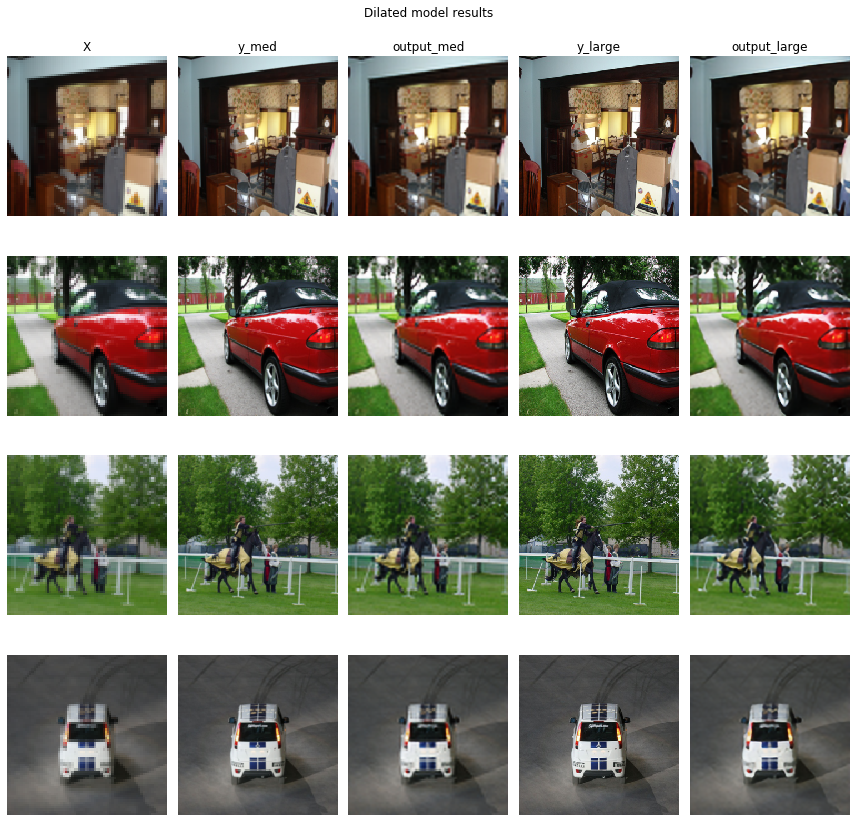

In [18]:
show_examples(examples, dilated_model, device, title='Dilated model results')

### Step 6: Feature Extraction using VGG16 Net

In [19]:
pre_trained_model = PreTrainedNet()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, pre_trained_model.parameters()), lr=LR)

Start training



Finished training


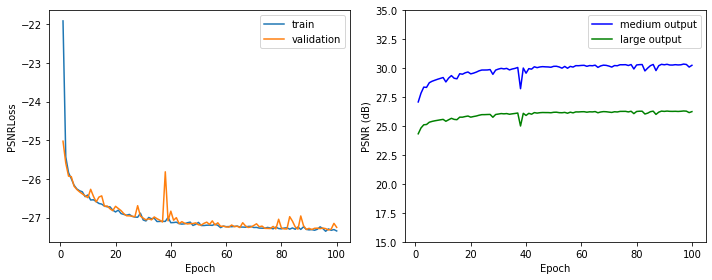

In [20]:
pre_trained_log = train(pre_trained_model, train_loader, val_loader, criterion, optimizer, device, 
                        num_epochs=NUM_EPOCHS, return_log=True)

torch.save(pre_trained_model, os.path.join(models_path, 'pre_trained_model.pt'))

pre_trained_df = pd.DataFrame(data=pre_trained_log, columns=columns_names)
pre_trained_df = pre_trained_df.join(pd.DataFrame(pre_trained_df['psnr'].values.tolist(), 
                                                  columns=['psnr_med', 'psnr_large'])).drop('psnr', axis=1)

pre_trained_df.to_csv(os.path.join(logs_path, 'pre_trained_model.csv'), header=True, index=False)


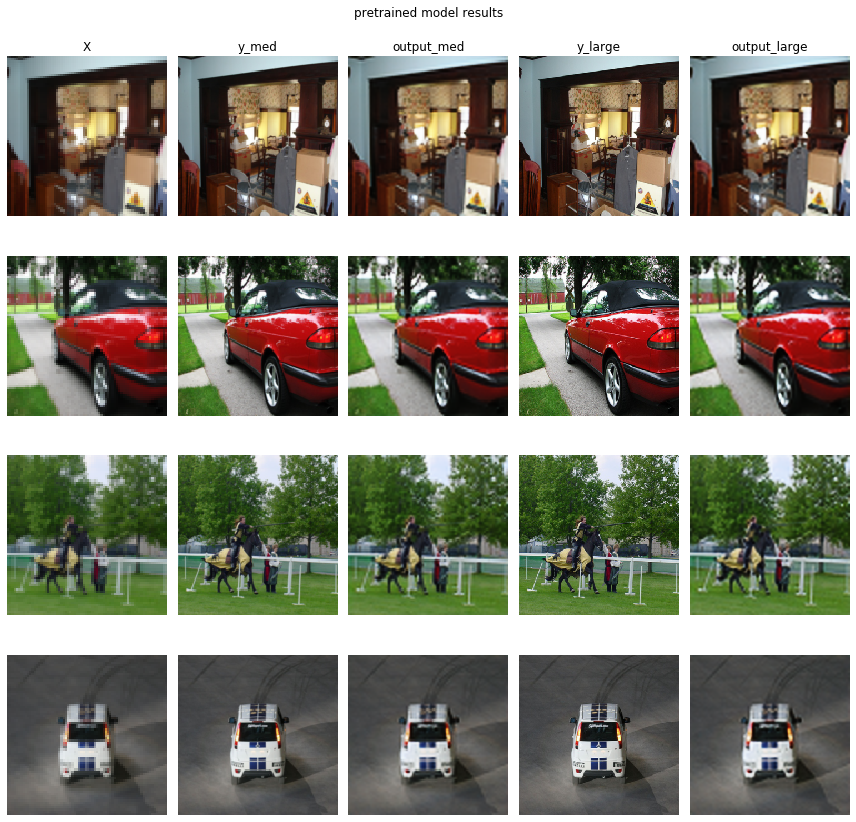

In [21]:
show_examples(examples, pre_trained_model, device, title='pretrained model results')

### Step 7: Pixel Shuffle

In [22]:
pixel_shuffled_model = PreTrainedNet(to_shuffle=True)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, pixel_shuffled_model.parameters()), lr=1e-3)

Start training



Finished training


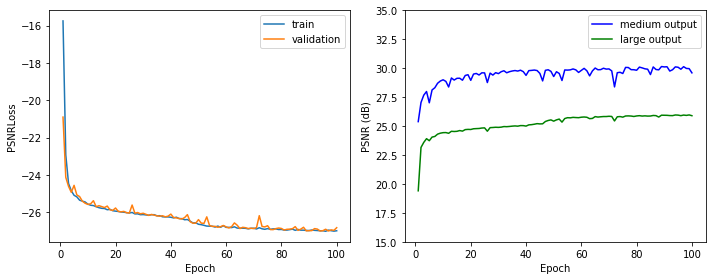

In [23]:
pixel_shuffled_log = train(pixel_shuffled_model, train_loader, val_loader, criterion, optimizer, device, 
                           num_epochs=NUM_EPOCHS, return_log=True)

torch.save(pixel_shuffled_model, os.path.join(models_path, 'pre_trained_model.pt'))

pixel_shuffled_df = pd.DataFrame(data=pixel_shuffled_log, columns=columns_names)
pixel_shuffled_df = pixel_shuffled_df.join(pd.DataFrame(pixel_shuffled_df['psnr'].values.tolist(),
                                                        columns=['psnr_med', 'psnr_large'])).drop('psnr', axis=1)

pixel_shuffled_df.to_csv(os.path.join(logs_path, 'pixel_shuffled_model.csv'), header=True, index=False)


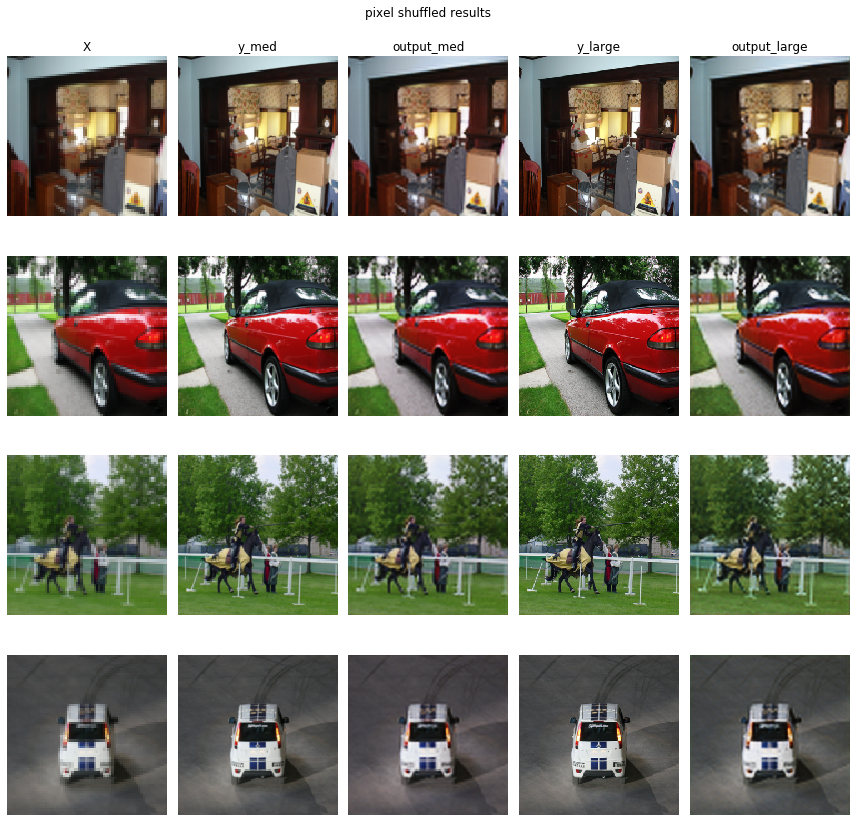

In [24]:
show_examples(examples, pixel_shuffled_model, device, title='pixel shuffled results')